<a href="https://colab.research.google.com/github/HayeonLee/sparsification_samsung/blob/master/bbdropout_samsung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Sparsification Example : Beta-Bernoulli Dropout

[Adaptive Network Sparsification with Dependent Variational Beta-Bernoulli Dropout](https://arxiv.org/abs/1805.10896)

## Import Tensorflow and other libraries

In [0]:
#from __future__ import absolute_import, division, print_function, unicode_literals
#기존에 설치된 다른 버전의 tensorflow를 제거합니다.
!pip uninstall tensorboard -y
!pip uninstall tensorflow-gpu -y
!pip uninstall tensorflow -y
#tensorflow gpu 버전을 설치합니다
!pip install tensorflow-gpu==1.14

Uninstalling tensorboard-1.14.0:
  Successfully uninstalled tensorboard-1.14.0
Uninstalling tensorflow-1.14.0:
  Successfully uninstalled tensorflow-1.14.0
     |████████████████████████████████| 377.0MB 49kB/s 
     |████████████████████████████████| 3.2MB 36.3MB/s 


In [0]:
import tensorflow as tf # tensorflow를 import해줍니다
tf.__version__ # 내가 사용할 tensorflow의 버전을 나타냅니다

'1.14.0'

In [0]:
# pretrain된 lenet의 체크포인트 파일을 가져옵니다.
!mkdir -p results/
!wget -O lenet_dense_pretrained.zip https://github.com/HayeonLee/sparsification_samsung/blob/master/lenet_dense_pretrained.zip?raw=true
!unzip lenet_dense_pretrained.zip -d results/
!rm lenet_dense_pretrained.zip
!ls
!ls results/pretrained/

--2019-07-23 05:33:12--  https://github.com/HayeonLee/sparsification_samsung/blob/master/lenet_dense_pretrained.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/HayeonLee/sparsification_samsung/raw/master/lenet_dense_pretrained.zip [following]
--2019-07-23 05:33:12--  https://github.com/HayeonLee/sparsification_samsung/raw/master/lenet_dense_pretrained.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HayeonLee/sparsification_samsung/master/lenet_dense_pretrained.zip [following]
--2019-07-23 05:33:12--  https://raw.githubusercontent.com/HayeonLee/sparsification_samsung/master/lenet_dense_pretrained.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to

In [0]:
# 필요한 라이브러리를 임포트합니다.
from __future__ import print_function
import time
import os
from pylab import *
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.contrib.distributions import RelaxedBernoulli
from tensorflow.examples.tutorials.mnist import input_data

## Define the functions and utils

In [0]:
tf.reset_default_graph() # 기존의 그려진 텐서플로우 그래프를 제거합니다.
# 자주 쓰는 텐서플로우 함수의 약어를 지정합니다.
logit = lambda x: tf.log(x + 1e-20) - tf.log(1-x + 1e-20)
softplus = tf.nn.softplus
relu = tf.nn.relu

dense = tf.layers.dense
flatten = tf.contrib.layers.flatten

def conv(x, filters, kernel_size=3, strides=1, **kwargs):
    return tf.layers.conv2d(x, filters, kernel_size, strides,
            data_format='channels_first', **kwargs)

def pool(x, **kwargs):
    return tf.layers.max_pooling2d(x, 2, 2,
            data_format='channels_first', **kwargs)

def global_avg_pool(x):
    return tf.reduce_mean(x, axis=[2, 3])

layer_norm = tf.contrib.layers.layer_norm

In [0]:
# utils/train.py
# 필요한 함수를 정의합니다.
def cross_entropy(logits, labels):
    return tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=labels)

def weight_decay(decay, var_list=None):
    var_list = tf.trainable_variables() if var_list is None else var_list
    return decay*tf.add_n([tf.nn.l2_loss(var) for var in var_list])

def accuracy(logits, labels):
    correct = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(correct, tf.float32))
  
def digamma_approx(x):
# @MISC {1446110,
# TITLE = {Approximating the Digamma function},
# AUTHOR = {njuffa (https://math.stackexchange.com/users/114200/njuffa)},
# HOWPUBLISHED = {Mathematics Stack Exchange},
# NOTE = {URL:https://math.stackexchange.com/q/1446110 (version: 2015-09-22)},
# EPRINT = {https://math.stackexchange.com/q/1446110},
# URL = {https://math.stackexchange.com/q/1446110}}
    def digamma_over_one(x):
        return tf.log(x + 0.4849142940227510) \
                - 1/(1.0271785180163817*x)
    return digamma_over_one(x+1) - 1./x

In [0]:
# log를 출력하기 위한 함수를 선언합니다.
class Accumulator():
    def __init__(self, *args):
        self.args = args
        self.argdict = {}
        for i, arg in enumerate(args):
            self.argdict[arg] = i
        self.sums = [0]*len(args)
        self.cnt = 0

    def accum(self, val):
        val = [val] if type(val) is not list else val
        val = [v for v in val if v is not None]
        assert(len(val) == len(self.args))
        for i in range(len(val)):
            self.sums[i] += val[i]
        self.cnt += 1

    def clear(self):
        self.sums = [0]*len(self.args)
        self.cnt = 0

    def get(self, arg, avg=True):
        i = self.argdict.get(arg, -1)
        assert(i is not -1)
        return (self.sums[i]/self.cnt if avg else self.sums[i])

    def print_(self, header=None, epoch=None, it=None, time=None,
            logfile=None, do_not_print=[], as_int=[],
            avg=True):
        line = '' if header is None else header + ': '
        if epoch is not None:
            line += ('epoch %d, ' % epoch)
        if it is not None:
            line += ('iter %d, ' % it)
        if time is not None:
            line += ('(%.3f secs), ' % time)

        args = [arg for arg in self.args if arg not in do_not_print]

        for arg in args[:-1]:
            val = self.sums[self.argdict[arg]]
            if avg:
                val /= self.cnt
            if arg in as_int:
                line += ('%s %d, ' % (arg, int(val)))
            else:
                line += ('%s %f, ' % (arg, val))
        val = self.sums[self.argdict[args[-1]]]
        if avg:
            val /= self.cnt
        if arg in as_int:
            line += ('%s %d, ' % (arg, int(val)))
        else:
            line += ('%s %f' % (args[-1], val))
        print(line)

        if logfile is not None:
            logfile.write(line + '\n')

## Prepare the dataset: MNIST

In [0]:
MNIST_PATH = './mnist'

def mnist_input(batch_size):
    mnist = input_data.read_data_sets(MNIST_PATH, one_hot=True, validation_size=0)
    n_train_batches = mnist.train.num_examples/batch_size
    n_test_batches = mnist.test.num_examples/batch_size
    return mnist, n_train_batches, n_test_batches

##Create models

In [0]:
# fully connected layers로 구성된 lenet을 선언합니다. 
def lenet_dense(x, y, training, name='lenet', reuse=None,
        dropout=None, **dropout_kwargs):
    dropout_ = lambda x, subname: x if dropout is None else \
            dropout(x, training, name=name+subname, reuse=reuse,
                    **dropout_kwargs)
    x = dense(dropout_(x, '/dropout1'), 500, activation=relu,
            name=name+'/dense1', reuse=reuse)
    x = dense(dropout_(x, '/dropout2'), 300, activation=relu,
            name=name+'/dense2', reuse=reuse)
    x = dense(dropout_(x, '/dropout3'), 10, name=name+'/dense3', reuse=reuse)

    net = {}
    all_vars = tf.get_collection('variables', scope=name)
    net['qpi_vars'] = [v for v in all_vars if 'qpi_vars' in v.name]
    net['pzx_vars'] = [v for v in all_vars if 'pzx_vars' in v.name]
    net['weights'] = [v for v in all_vars \
            if 'qpi_vars' not in v.name and 'pzx_vars' not in v.name]

    net['cent'] = cross_entropy(x, y)
    net['wd'] = weight_decay(1e-4, var_list=net['weights'])
    net['acc'] = accuracy(x, y)

    prefix = 'train_' if training else 'test_'
    net['kl'] = tf.get_collection('kl')
    net['pi'] = tf.get_collection(prefix+'pi')
    net['n_active'] = tf.get_collection(prefix+'n_active')

    return net

# def lenet_conv(x, y, training, name='lenet', reuse=None,
#         dropout=None, **dropout_kwargs):
#     dropout_ = lambda x, subname: x if dropout is None else \
#             dropout(x, training, name=name+subname, reuse=reuse,
#                     **dropout_kwargs)
#     x = tf.reshape(x, [-1, 1, 28, 28])
#     x = conv(x, 20, 5, name=name+'/conv1', reuse=reuse)
#     x = relu(dropout_(x, '/dropout1'))
#     x = pool(x, name=name+'/pool1')
#     x = conv(x, 50, 5, name=name+'/conv2', reuse=reuse)
#     x = relu(dropout_(x, '/dropout2'))
#     x = pool(x, name=name+'/pool2')
#     x = flatten(x)
#     x = dense(dropout_(x, '/dropout3'), 500, activation=relu,
#             name=name+'/dense1', reuse=reuse)
#     x = dense(dropout_(x, '/dropout4'), 10, name=name+'/dense2', reuse=reuse)

#     net = {}
#     all_vars = tf.get_collection('variables', scope=name)
#     net['qpi_vars'] = [v for v in all_vars if 'qpi_vars' in v.name]
#     net['pzx_vars'] = [v for v in all_vars if 'pzx_vars' in v.name]
#     net['weights'] = [v for v in all_vars \
#             if 'qpi_vars' not in v.name and 'pzx_vars' not in v.name]

#     net['cent'] = cross_entropy(x, y)
#     net['wd'] = weight_decay(1e-4, var_list=net['weights'])
#     net['acc'] = accuracy(x, y)

#     prefix = 'train_' if training else 'test_'
#     net['kl'] = tf.get_collection('kl')
#     net['pi'] = tf.get_collection(prefix+'pi')
#     net['n_active'] = tf.get_collection(prefix+'n_active')

#     return net


## Define the Beta-Bernoulli Dropout

In [0]:
lgamma = tf.lgamma
Euler = 0.577215664901532

def bbdropout(x, training,
        alpha=1e-4, thres=1e-2, a_init=-1., tau=1e-1, center_init=1.0,
        approx_digamma=True, scale_kl=None, dep=False,
        unit_scale=True, collect=True,
        name='bbdropout', reuse=None):

    N = tf.shape(x)[0]
    K = x.shape[1].value
    is_conv = len(x.shape)==4
    log = lambda x: tf.log(x + 1e-20)

    with tf.variable_scope(name+'/qpi_vars', reuse=reuse):
        with tf.device('/cpu:0'):
            a = softplus(tf.get_variable('a_uc', shape=[K],
                initializer=tf.constant_initializer(a_init)))
            b = softplus(tf.get_variable('b_uc', shape=[K]))

    _digamma = digamma_approx 
    kl = (a-alpha)/a * (-Euler - _digamma(b) - 1/b) \
            + log(a*b) - log(alpha) - (b-1)/b
    pi = (1 - tf.random_uniform([K])**(1/b))**(1/a) if training else \
            b*tf.exp(lgamma(1+1/a) + lgamma(b) - lgamma(1+1/a+b))
    
    if training:
        z = RelaxedBernoulli(tau, logits=logit(pi)).sample(N)
    else:
        pi_ = tf.where(tf.greater(pi, thres), pi, tf.zeros_like(pi))
        z = tf.tile(tf.expand_dims(pi_, 0), [N, 1])
    n_active = tf.reduce_sum(tf.cast(tf.greater(pi, thres), tf.int32))

    if scale_kl is None:
        kl = tf.reduce_sum(kl)
    else:
        kl = scale_kl * tf.reduce_mean(kl)

    if collect:
        if reuse is not True:
            tf.add_to_collection('kl', kl)
        prefix = 'train_' if training else 'test_'
        tf.add_to_collection(prefix+'pi', pi)
        tf.add_to_collection(prefix+'n_active', n_active)

    z = tf.reshape(z, ([-1, K, 1, 1] if is_conv else [-1, K]))
    return x*z


## Let's run the code!

In [0]:
pretraindir = './results/pretrained' 
savedir = './results/bbdropout/sample_run' 
if not os.path.isdir(savedir):
    os.makedirs(savedir)

batch_size = 100
n_epochs = 60
save_freq = 20
mnist, n_train_batches, n_test_batches = mnist_input(batch_size)
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
N = mnist.train.num_examples
dropout = bbdropout
net = lenet_dense(x, y, True, dropout=dropout)
tnet = lenet_dense(x, y, False, reuse=True, dropout=dropout)

def train():
    loss = net['cent'] + tf.add_n(net['kl'])/float(N) + net['wd'] 
    global_step = tf.train.get_or_create_global_step()
    bdr = [int(n_train_batches*(n_epochs-1)*r) for r in [0.5, 0.75]]
    vals = [1e-2, 1e-3, 1e-4]
    lr = tf.train.piecewise_constant(tf.cast(global_step, tf.int32), bdr, vals)
    train_op1 = tf.train.AdamOptimizer(lr).minimize(loss,
            var_list=net['qpi_vars'], global_step=global_step)
    train_op2 = tf.train.AdamOptimizer(0.1*lr).minimize(loss,
            var_list=net['weights'])
    train_op = tf.group(train_op1, train_op2)

    pretrain_saver = tf.train.Saver(net['weights'])
    saver = tf.train.Saver(net['weights']+net['qpi_vars'])
    logfile = open(os.path.join(savedir, 'train.log'), 'w', 0)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    pretrain_saver.restore(sess, os.path.join(pretraindir, 'model'))

    train_logger = Accumulator('cent', 'acc')
    train_to_run = [train_op, net['cent'], net['acc']]
    test_logger = Accumulator('cent', 'acc')
    test_to_run = [tnet['cent'], tnet['acc']]
    for i in range(n_epochs):
        line = 'Epoch %d start, learning rate %f' % (i+1, sess.run(lr))
        print(line)
        logfile.write(line + '\n')
        train_logger.clear()
        start = time.time()
        for j in range(n_train_batches):
            bx, by = mnist.train.next_batch(batch_size)
            train_logger.accum(sess.run(train_to_run, {x:bx, y:by}))
        train_logger.print_(header='train', epoch=i+1,
                time=time.time()-start, logfile=logfile)

        test_logger.clear()
        for j in range(n_test_batches):
            bx, by = mnist.test.next_batch(batch_size)
            test_logger.accum(sess.run(test_to_run, {x:bx, y:by}))
        test_logger.print_(header='test', epoch=i+1,
                time=time.time()-start, logfile=logfile)
        #line = 'kl: ' + str(sess.run(tnet['kl'])) + '\n'
        line += 'n_active: ' + str(sess.run(tnet['n_active'])) + '\n'
        print(line)
        logfile.write(line+'\n')

        if (i+1)% save_freq == 0:
            saver.save(sess, os.path.join(savedir, 'model'))

    logfile.close()
    saver.save(sess, os.path.join(savedir, 'model'))

In [0]:
train()

W0723 05:34:16.192369 139630325450624 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Epoch 1 start, learning rate 0.010000
train: epoch 1, (5.304 secs), cent 0.413326, acc 0.877817
test: epoch 1, (5.596 secs), cent 0.110209, acc 0.967600
kl: [4585.8677, 3876.8252, 2495.3503]
n_active: [523, 469, 297]

Epoch 2 start, learning rate 0.010000
train: epoch 2, (4.134 secs), cent 0.164370, acc 0.949483
test: epoch 2, (4.369 secs), cent 0.083183, acc 0.973700
kl: [4452.902, 3971.1667, 2566.4827]
n_active: [511, 467, 297]

Epoch 3 start, learning rate 0.010000
train: epoch 3, (4.131 secs), cent 0.125859, acc 0.960067
test: epoch 3, (4.362 secs), cent 0.067286, acc 0.978200
kl: [4552.4395, 4077.387, 2617.6377]
n_active: [503, 465, 296]

Epoch 4 start, learning rate 0.010000
train: epoch 4, (4.080 secs), cent 0.101211, acc 0.968267
test: epoch 4, (4.315 secs), cent 0.061414, acc 0.980100
kl: [4632.4185, 4125.4053, 2639.4167]
n_active: [499, 463, 296]

Epoch 5 start, learning rate 0.010000
train: epoch 5, (4.065 secs), cent 0.087104, acc 0.972150
test: epoch 5, (4.302 secs), cent 

## Test

In [0]:
def test():
    sess = tf.Session()
    saver = tf.train.Saver(tnet['weights']+tnet['qpi_vars'])
    saver.restore(sess, os.path.join(savedir, 'model'))
    logger = Accumulator('cent', 'acc')
    to_run = [tnet['cent'], tnet['acc']]
    for j in range(n_test_batches):
        bx, by = mnist.test.next_batch(batch_size)
        logger.accum(sess.run(to_run, {x:bx, y:by}))
    logger.print_(header='test')
    
    n_active = sess.run(tnet['n_active'])
    print("The percentage of activated neurons per layer:")
    for na, nl in zip(n_active, [784, 500, 300]):
      print('{}/{} = {:.2f}%'.format(na, nl, float(na)/nl * 100))
    
test()

test: cent 0.041238, acc 0.987600
The percentage of activated neurons per layer
358/784 = 45.66%
209/500 = 41.80%
152/300 = 50.67%


## Visualization

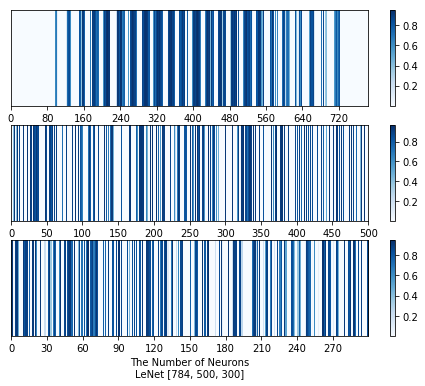

In [0]:
def visualize():
    sess = tf.Session()
    saver = tf.train.Saver(tnet['weights']+tnet['qpi_vars'])
    saver.restore(sess, os.path.join(savedir, 'model'))

    n_drop = len(tnet['n_active'])
    fig = figure('pi', figsize=(8,6))
    axarr = fig.subplots(n_drop)
    for i in range(n_drop):
        np_pi = sess.run(tnet['pi'][i]).reshape((1,-1))
        im = axarr[i].imshow(np_pi, cmap='Blues', aspect='auto')
        axarr[i].yaxis.set_visible(False)
        axarr[i].xaxis.set_major_locator(MaxNLocator(integer=True))
        if i == n_drop-1:
            axarr[i].set_xlabel('The Number of Neurons\nLeNet [784, 500, 300]')
        fig.colorbar(im, ax=axarr[i])
    show()
visualize()